In [1]:
import os
import math
import time
import numpy as np
import scipy as sp
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
%matplotlib inline
#%matplotlib notebook
%load_ext autoreload
%autoreload 2

# Functions
## <span style='color:crimson'>Visualization</span>

In [3]:
# visualization
def plot_config(xyz,L, n, c='dodgerblue'):
    
    n = n-1
    fig = plt.figure(figsize=(size,size))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xyz[0,0], xyz[0,1], xyz[0,2], s = 2000, color='green')
    ax.scatter(xyz[1,0], xyz[1,1], xyz[1,2], s = 2000, color='cyan')
    ax.scatter(xyz[2:n,0], xyz[2:n, 1], xyz[2:n,2], s = 2000, color=c)
    ax.scatter(xyz[n,0], xyz[n,1], xyz[n,2], s = 2000, color='green')
    
    if interrupt == True:
        ax.scatter(xyz[lastmon,0], xyz[lastmon,1], xyz[lastmon,2], s = 2000, color='crimson')
    
    ax.plot(xyz[:,0],xyz[:,1],xyz[:,2], color='r',alpha=0.4)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    ax.set_xlim(0,L)
    ax.set_ylim(0,L)
    ax.set_zlim(0,L)
    ax.grid(True)
    
    plt.show()

## <span style='color:crimson'>Periodic Boundary Conditions</span>

In [4]:
# wrapping to box
def wrap(r,L):

    if r[0] >= L:
        r[0] -= L
    elif r[0] < 0:
        r[0] += L
    if r[1] >= L:
        r[1] -= L
    elif r[1] < 0:
        r[1] += L
    if r[2] >= L:
        r[2] -= L
    elif r[2] < 0:
        r[2] +=L 
    return r

## <span style='color:crimson'>Distance between two position vectors</span>

In [5]:
# pairwise distance
def dist(r1,r2,L):
    
    halfL = L/2.
    
    dx = r2[0]-r1[0]
    dy = r2[1]-r1[1]
    dz = r2[2]-r1[2]

    if dx >= halfL:
        dx -= L
    elif dx < -halfL:
        dx += L
    if dy >= halfL:
        dy -= L
    elif dy < -halfL:
        dy += L
    if dz >= halfL:
        dz -= L
    elif dz < -halfL:
        dz += L

    return math.sqrt(dx**2+dy**2+dz**2)

# Parameters
## <span style='color:crimson'> User-defined parameters</span>
* Coordinates for position choices
* Number of possibilities, $k$
* Maximum number of recoil steps, $l_max$
* Size of the lattice
* Number of monomers per chain

In [6]:
# Coordinates for position choices
positions_xyz = [[1,1,1],[1,1,-1],[1,-1,1],[1,-1,-1],[-1,1,1],[-1,1,-1],[-1,-1,1],[-1,-1,-1]]

# Number of possibilities
k = 4

# Recoil steps allowed
lmax = 2

# Squared Lattice of 10-by-10spaces available
size = 15

# 10 Monomers having positions in 2 coordinates (x, y, z)
N = 30

# Initializing Grid and Chain Coordinates

## <span style='color:crimson'>Lattice</span>
In the lattice a $0$ indicates there is no particle in that position. A $1$ indicates there is a particle inserted there. A $-1$ indicates we can't try that position any more.

## <span style='color:crimson'>Chain Coordinates</span>
Since $(0,0)$ is a real position in the grid, we initialize the coordinates of all particles with NaN so that they won't be plotted in the grid.

In [7]:
# Initializing grid with 0s
lattice = np.zeros((size,size,size))

# Initializing position off lattice because (0,0,0) is an actual position
xyz = np.full((N, 3), np.nan)

# Array to record which of the k position possibilities we have tried
positions_idx = np.zeros((N, k))

# POLYMER 1
## <span style='color:crimson'> Insertion of monomer 0 </span>
Monomer 0 is inserted at random in the lattice. We must verify there's nothing else in the position we randomly selected for its insertion

In [8]:
retry = True

while retry == True:
    # Random Coordinate generation
    ran = np.random.randint(size, size=3)

    # Possible Coordinates for monomer 0
    xcoord = int(ran[0])
    ycoord = int(ran[1])
    zcoord = int(ran[2])

    # Recording position in lattice
    if lattice[ycoord][xcoord][zcoord] == 0:
        xyz[0] = ran
        lattice[ycoord][xcoord][zcoord] = 1
        retry = False

## <span style='color:crimson'> Insertion of monomer 1-N </span>

Monomer $i$ should be inserted in any of $k=4$ possible directions from monomer $i-1$:
* **Position 0:** $x+1$,$y+1$
* **Position 1:** $x+1$, $y-1$
* **Position 2:** $x-1$, $y+1$
* **Position 3:** $x-1$, $y-1$

In [9]:
# We start from monomer 1
mon = 1

# Used to determine when to stop the recoil steps
counter = 0

while mon < N:
    
    # Finding available positions for previous monomer
    available = np.where(positions_idx[mon]==0)
    b = available[0].tolist()

    # Previous monomer for reference of location
    prev = mon -1
    print('\nMONOMER #', mon)

    while len(b) > 0:
        pos = random.choice(b)
        b.remove(pos)
        print('Attempt Position #%d' %(pos))

        # Possible Coordinates for monomer mon
        xcoord = int(xyz[prev][0])+ positions_xyz[pos][0]
        ycoord = int(xyz[prev][1])+ positions_xyz[pos][1]
        zcoord = int(xyz[prev][2])+ positions_xyz[pos][2]
        
        # Creating temporary vector with possible coordinates for monomer mon
        xyz_mon_new = [xcoord, ycoord, zcoord]

        # Periodic boundary conditions
        xyz_mon_wrap = wrap(xyz_mon_new, size)
        xcoord = xyz_mon_wrap[0]
        ycoord = xyz_mon_wrap[1]
        zcoord = xyz_mon_wrap[2]
        
        # If there is no monomer in that position
        if lattice[xcoord][ycoord][zcoord] == 0:
            find = True 
            recoil = False
            print('Successful placement at position#%d: (%d, %d, %d)' %(pos, xcoord, ycoord, zcoord))

            #Recording accepted attempt in array
            positions_idx[mon][pos] = 1

            # Set Coordinates for monomer mon
            xyz[mon] = [xcoord, ycoord, zcoord]

            # Record position in lattice
            lattice[xcoord][ycoord][zcoord] = 1
            
            # Inform the chain was completely placed
            if mon == N-1:
                print('We did it!!')
                lastmon = mon
                interrupt = False
            
            mon += 1
            
            break

        else:
            print('Position #%d at (%d, %d, %d) is unavailable'%(pos, xcoord,ycoord,zcoord))
            
            #Recording unsuccessful attempt in array
            positions_idx[mon][pos] = -1

            if len(b) == 0:
                recoil = True
                print(positions_idx)
                print('DEAD ALLEY!!!!!!')
                break
                
    if recoil == True:        
        
        # Finding index of previous monomer and changing it to -1 because it's no longer useful
        used = np.where(positions_idx[prev]==1)
        positions_idx[prev][used[0][0]] = -1
        print('Changing current position of monomer %d to -1' %(prev))
        print(positions_idx)
        
        # Resetting next monomer indices to 0 because we are changing the chain
        positions_idx[mon][:] = 0
        print('Resetting indices of monomer %d' %mon)
        print(positions_idx)
        
        # Resetting position of previous monomer in lattice
        print('Resetting position of previous monomer in lattice')
        xcoord = int(xyz[prev][0])
        ycoord = int(xyz[prev][1])
        zcoord = int(xyz[prev][2])
        lattice[xcoord][ycoord][zcoord] = 0
        
        print('Resetting position of previous monomer')
        xyz[prev] = np.nan
        
        # Changing monomer perspective: Starting over from previous monomer
        mon = mon-1
        
        print('RECOIL to monomer %d...'%(mon))
        print('----------------------------------')
        
       
        ####################################################
        ########### Setting recoil-step limit ##############
        ####################################################
        counter += 1
        
        # Saving the maximum length of the chain for the first recoil
        if counter == 1:
            maxchain = mon
        
        # If it recoils back to lmax steps from maxchain, it won't continue recoiling
        if mon == (maxchain - lmax):
            interrupt = True
            print('Enough is enough')
            lastmon = mon - 1
            break
            
        # If the chain grows bigger than the previous maximum length of the chain
        # We reset the counter so that the new monomer can go back down to lmax positions
        if mon > maxchain:
            counter = 0
        
        # Deactivating recoil step
        recoil = False


MONOMER # 1
Attempt Position #0
Successful placement at position#0: (6, 6, 3)

MONOMER # 2
Attempt Position #3
Successful placement at position#3: (7, 5, 2)

MONOMER # 3
Attempt Position #0
Successful placement at position#0: (8, 6, 3)

MONOMER # 4
Attempt Position #0
Successful placement at position#0: (9, 7, 4)

MONOMER # 5
Attempt Position #0
Successful placement at position#0: (10, 8, 5)

MONOMER # 6
Attempt Position #1
Successful placement at position#1: (11, 9, 4)

MONOMER # 7
Attempt Position #2
Successful placement at position#2: (12, 8, 5)

MONOMER # 8
Attempt Position #3
Successful placement at position#3: (13, 7, 4)

MONOMER # 9
Attempt Position #3
Successful placement at position#3: (14, 6, 3)

MONOMER # 10
Attempt Position #1
Successful placement at position#1: (0, 7, 2)

MONOMER # 11
Attempt Position #2
Successful placement at position#2: (1, 6, 3)

MONOMER # 12
Attempt Position #1
Successful placement at position#1: (2, 7, 2)

MONOMER # 13
Attempt Position #3
Successful

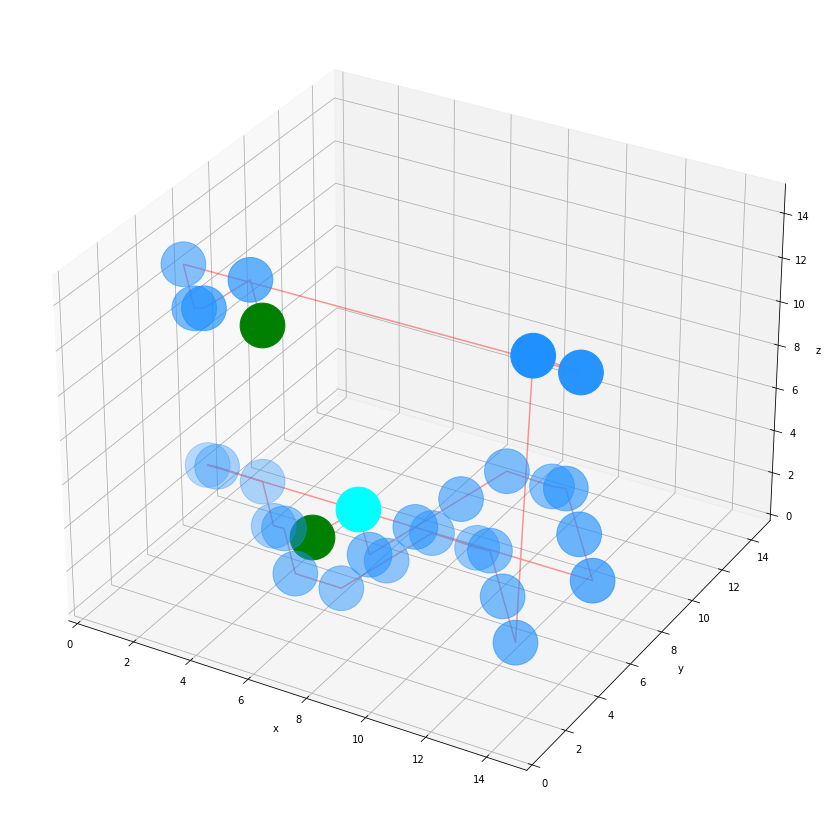

In [10]:
plot_config(xyz, size, N)

In [11]:
r1 = xyz[0]
r2 = xyz[lastmon]
print('The end-to-end distance of the chain is:', dist(r1, r2, size),'units')
print('The bondlength is √2 units')

The end-to-end distance of the chain is: 5.196152422706632 units
The bondlength is √2 units
